<a href="https://colab.research.google.com/github/claudia-hm/IRMAS_Deep_Learning/blob/master/IRMAS_Deep_Learning_bis_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final project : Instrument recognition in musical audio signals

The goal of the project is to construct a neural network able to differentiate musical instruments in audio excerpts in the IRMAS dataset.

# 0. Preliminaries

### Mount drive

In [1]:
##Opening Data And saving

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

!ls '/content/drive/My Drive/DeepLearning_2020/IRMAS_Deep_Learning/Data/'

data_path = '/content/drive/My Drive/DeepLearning_2020/IRMAS_Deep_Learning/Data/'
results_path = '/content/drive/My Drive/DeepLearning_2020/IRMAS_Deep_Learning/Results/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cel			  flu		 labels.npy  specs_11.npy  voi
cla			  gac		 org	     specs.npy
data_11_instruments.json  gel		 pia	     tru
data_jason.json		  labels_11.npy  sax	     vio


### Install required packages

Essentia is an open-source library and tools for audio and music analysis, description and synthesis (https://essentia.upf.edu)

In [2]:
%%capture
!pip install essentia

### Imports

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

%tensorflow_version 2.x
import tensorflow as tf
import timeit

import os
import json

import sys
from tqdm.auto import tqdm
import essentia.standard as es
from essentia import Pool
import sklearn

import random
import librosa.display
from IPython.display import Audio

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


Using TensorFlow backend.


### Data checking

Check if the Data folder exists:

In [4]:
isData = os.path.isdir(data_path)  
if(not isData):
  print("An error occured when searching for the Data directory, please download it and include it at /content/drive/My Drive/DeepLearning_2020/IRMAS_Deep_Learning/Data/")
  print("Download link: https://drive.google.com/drive/folders/1PCZbU3EFrr0Ek2II3MtZ8QsX-o3S0cMA?usp=sharing")
  sys.exit()

### Warm up CPU and GPU

In this step we check that both CPUs and GPUs are available and compare the time they take to convolve a 37x7x7x filter over a random image. 

In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.753388221000023
GPU (s):
0.1867245799999182
GPU speedup over CPU: 20x


# 1. Data loading and pre-processing

In this project, we will use the Instrument Recognition in Musical Audio Signals, IRMAS, dataset (https://www.upf.edu/web/mtg/irmas). It contains labeled musical audio excerpts by its predominant instrument.  The instruments considered are: cello, clarinet, flute, acoustic guitar, electric guitar, organ, piano, saxophone, trumpet, violin, and human singing voice. 

For this project, we will use only the training dataset of the original IRMAS because our goal is to classify audio excerpts with only one predominant instrument, and the original testing dataset contains audio signals with more than one predominant instrument. In this notebook we will test the behaviour of the VGG-like model implemented in the first notebook in an 11 class problem.

Bosch, J. J., Janer, J., Fuhrmann, F., & Herrera, P. “A Comparison of Sound Segregation Techniques for Predominant Instrument Recognition in Musical Audio Signals”, in Proc. ISMIR (pp. 559-564), 2012

###Store filenames in dataset

This dictionary maps folder names (alias for musical instruments) to numerical indexes.

In [6]:
CLASS_MAPPING = {
  'voi':0,
  'vio':1,
  'tru':2, 
  'sax':3,
  'pia':4, 
  'org':5,
  'gel':6,
  'gac':7,
  'flu':8, 
  'cla':9,
  'cel':10

}

First, we store the filenames in a dictionary, where the keys are the folder names (as in CLASS_MAPING)

In [7]:
audio_files = dict()

for i in CLASS_MAPPING.keys():
  files = []
  for filename in os.listdir(data_path + "/" + i + "/"):      
    files.append(filename)
  audio_files[i] = files

###Save json file in the Data folder

Then, we save the previously created dictionary in a json file

In [8]:
with open(data_path +'/data_11_instruments.json', 'w') as outfile:
    json.dump(audio_files, outfile)

### Functions to compute spectogram

To classify samples we will compute their Log Mel Spectrograms using Essentia library. These are Spectrogram with the Log Mel Scale as its y axis.  This Mel Scale is constructed such that sounds of equal distance from each other on the Mel Scale, also “sound” to humans as they are equal in distance from one another. (https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0)

In [9]:
def pad(l, sr):
    # 0-Pad 10 sec at fs hz and add little noise
    z = np.zeros(10*sr, dtype='float32')
    z[:l.size] = l
    z = z + 5*1e-4*np.random.rand(z.size).astype('float32')
    return z


def compute_spectrogram(filename, sr=16000, n_mels=64):
    # compute log mel magnitude spectrogram 
    audio = es.MonoLoader(filename=filename,sampleRate=sr)()
    audio = pad(audio, sr)
    
    # essentia extractor
    windowing = es.Windowing(type='hann', normalized=False, zeroPadding=0)
    spectrum = es.Spectrum()
    melbands = es.MelBands(numberBands=n_mels, 
                           sampleRate=sr, 
                           lowFrequencyBound=0, 
                           highFrequencyBound=8000, 
                           inputSize=(2048)//2+1, 
                           weighting='linear', 
                           normalize='unit_tri', 
                           warpingFormula='slaneyMel', 
                           type='power')
    
    norm10k = es.UnaryOperator(type='identity', shift=0, scale=1)
    log10 = es.UnaryOperator(type='log10')
    results = Pool()

    for frame in es.FrameGenerator(audio, frameSize=1024, hopSize=512, startFromZero=False):
        spectrumFrame = spectrum(windowing(frame))     
        results.add('melbands', log10(norm10k(melbands(spectrumFrame))))
    
    mel_log_spectrum = results['melbands']
    return mel_log_spectrum[:64].T

### Example of computing spectrogram

Here, we show an example of computing a spectrogram from a random file in the dataset. Also, the random track can be reproduced.

Filename: [gac][pop_roc]0578__3.wav


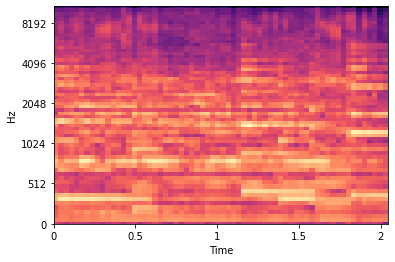

In [10]:
#select random file
random_instrument = random.choice(list(CLASS_MAPPING.keys()))
rand_sound = random.choice(audio_files[random_instrument])
data_rand_instrument = data_path + '/' + random_instrument + '/'


#compute spectrogram and reproduce the track
x = compute_spectrogram(f'{data_rand_instrument}/{rand_sound}')
librosa.display.specshow(x, sr=16000, x_axis='time', y_axis='mel')

print("Filename: " + rand_sound)
Audio(f'{data_rand_instrument}/{rand_sound}')

### Compute spectrogram for whole dataset

If this cell is activated to true, it will recompute all the spectrograms for the files in the dataset. It takes approximately 30 minutes to complete. For this reason, we have stored them in the file specs.npy and the labels in labels.npy.

In [11]:
if False:
    dataset = json.load(open(data_path+'/data_11_instruments.json', 'rb'))
    num_sounds = sum([len(v) for _, v in dataset.items()])
    num_classes = len(dataset)

    specs = np.zeros((num_sounds, 64, 64))
    labels = np.zeros((num_sounds,))

    idx = 0

    with tqdm(total=num_sounds) as pbar:
        for class_name, sounds in dataset.items():
            for sound in sounds:
                specs[idx] = compute_spectrogram(f'{data_path}{class_name}/{sound}')
                # labels[idx][NSYNTH_CLASS_MAPPING[class_name]] = 1
                labels[idx] = CLASS_MAPPING[class_name]
                idx += 1
                pbar.update()

    np.save(data_path+'specs_11.npy', specs)
    np.save(data_path+'labels_!1.npy', labels)

# 2. Create custom datasaet

First, we load the numpy files that contain the spectrograms and labels.

In [12]:
specs = np.load(data_path+'specs_11.npy')
labels = np.load(data_path+'labels_11.npy')

#reshape the spectrograms
specs = specs.reshape(-1, 64, 64, 1)
#specs = (specs - np.mean(specs)) / np.std(specs)

# split train test
X_train, X_test, y_train, y_test = train_test_split(specs, labels, test_size=0.2, random_state=42)

print("There are " + str(len(X_train)) + " training samples and " + str(len(X_test))+ " testing samples.")


There are 5364 training samples and 1341 testing samples.


Then, following the procedure presented in S2, we have created a Dataset class for the IRMAS data.

In [13]:
#Making native class loader
class IRMAS(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self, X_train, y_train):
        self.data = torch.from_numpy(X_train.astype(float))
        self.labels = torch.from_numpy(y_train.astype(float)).squeeze()

    
    # What to do to load a single item in the dataset (read image and label)    
    def __getitem__(self, index):
        data = self.data[index]
        lbl = self.labels[index]

        data = np.transpose(data, axes=[2,0,1])

        return data,lbl
    
    
        pass
    
    # Return the number of images
    def __len__(self):
        return len(self.data)
      

We instantiate the dataset for training and the train_loader.

In [14]:
IRMAS_example = IRMAS(X_train, y_train)
example_loader = torch.utils.data.DataLoader(dataset=IRMAS_example,
                                               batch_size=8,  
                                               shuffle=True)


Here we show an example of usage of the data loader, extracting spectrograms from our dataset.

torch.Size([8, 1, 64, 64]) torch.Size([8])
lbl :  tensor(2., dtype=torch.float64)


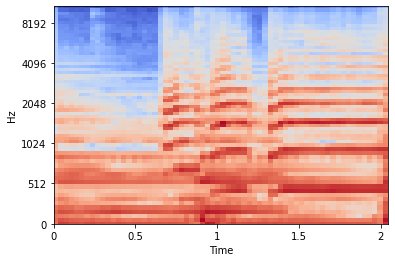

lbl :  tensor(0., dtype=torch.float64)


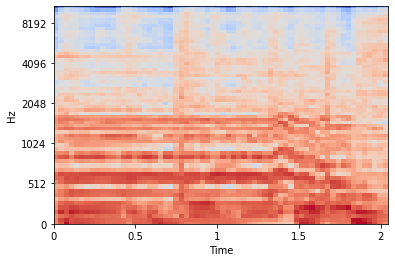

lbl :  tensor(4., dtype=torch.float64)


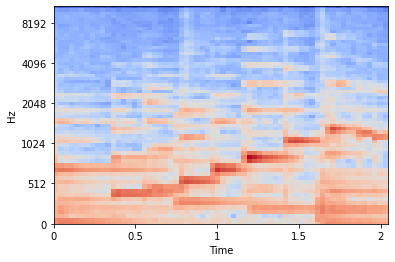

lbl :  tensor(9., dtype=torch.float64)


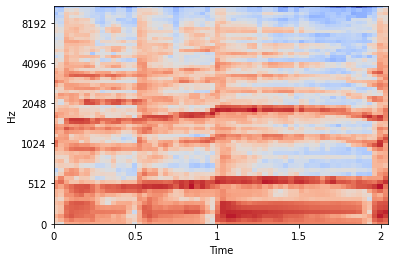

lbl :  tensor(2., dtype=torch.float64)


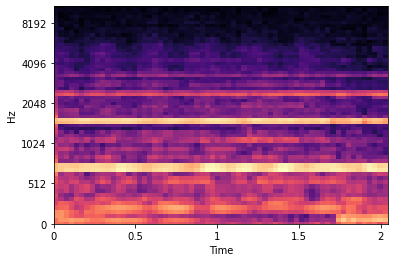

lbl :  tensor(4., dtype=torch.float64)


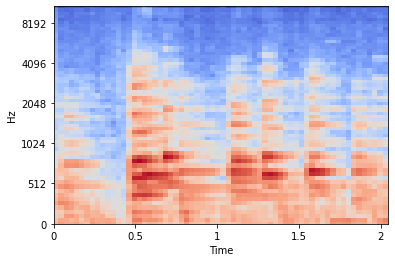

lbl :  tensor(4., dtype=torch.float64)


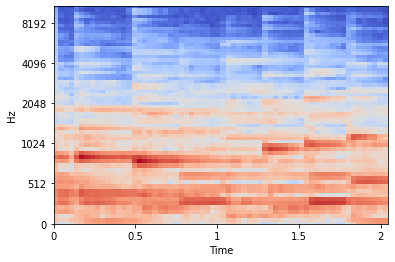

lbl :  tensor(7., dtype=torch.float64)


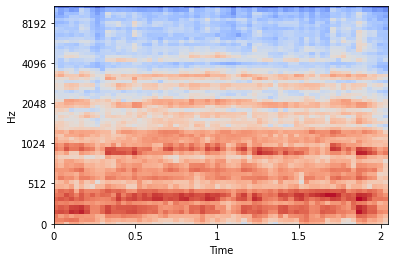

In [15]:
for images, labels in example_loader:
  print(images.shape, labels.shape) #images, labels shape
  for img,lbl in zip(images,labels): 
    print('lbl : ',lbl)
    librosa.display.specshow(img.squeeze().numpy(), sr=16000, x_axis='time', y_axis='mel')
    plt.show()
  break

# 3. Define the model

Our model is based in the VGG network. The main characteristics are: 3x3 convolutional filters, fully connected layers at the end, and ReLU activation functions.

In [16]:
class VGG(nn.Module):
    def __init__(self, num_classes=11):
        
        super(VGG, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.batch1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.batch2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.batch3 = nn.BatchNorm2d(64)


        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.batch4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.batch5 = nn.BatchNorm2d(128)
        
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.batch6 = nn.BatchNorm1d(2*2*128)
        self.fc1 = nn.Linear(2*2*128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim = 1)

        self.dropout2d = nn.Dropout2d(0.05)
        
    def forward(self, x):

        out = self.relu(self.conv1(x))
        out = self.batch1(out)
        out = self.maxpool(out) # 32x32x16 --> 1x16x32x32

        out = self.relu(self.conv2(out))
        out = self.batch2(out)
        out = self.maxpool(out) # 16x16x32

        out = self.relu(self.conv3(out))
        out = self.batch3(out)
        out = self.maxpool(out) # 8x8x64

        out = self.relu(self.conv4(out))
        out = self.batch4(out)
        out = self.maxpool(out) # 4x4x128

        out = self.relu(self.conv5(out))
        out = self.batch5(out)
        out = self.maxpool(out) # 2x2x128

        out = out.view(out.size(0), -1) # 512

        out = self.dropout(out) # 512

        out = self.batch6(out) # 512
        
        out = self.relu(self.fc1(out)) # 64

        out = self.softmax(self.fc2(out)) # num_classes

        return out

Here we instantiate our model and print the information related to each of the layers.

In [17]:
vgg = VGG()
vgg = vgg.cuda()
print(vgg)

VGG(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten()
  (dropout): Dropout(p=0.5, inplace=False)
  (batch6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running

# 4. Creating loss function, optimizers and hyperparameters

For this task we use Cross Entropy Loss and Adam optimizer. The learning rate is set to 0.001 and the number of epochs to 30.

In [18]:
# Cross entropy loss for classification problems
criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(vgg.parameters(),lr = learning_rate)

# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 40

# 5. Actual training

In this section, we train our model using the described hyperparameters and the IRMAS dataset.

In [19]:
# Train the model
if True :
    IRMASTrain = IRMAS(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(dataset=IRMASTrain,
                                               batch_size=64,    
                                               shuffle=True)
    vgg.train() # Set the model in train mode
    total_step = len(train_loader)
    
    loss_list = []

    # Iterate over epochs
    for epoch in range(num_epochs):
        total_loss = 0
        # Iterate the dataset
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device).float()
            labels = labels.to(device).float()

            # Forward pass
            outputs = vgg(images)
            loss = criterion(outputs, labels.long())
            total_loss+=loss
                        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 20 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
        avg_loss = total_loss/total_step
        loss_list.append(avg_loss)
    
    # Save the model checkpoint
    torch.save(vgg.state_dict(), results_path+'/vgg_model_11.ckpt')
    #to load : model.load_state_dict(torch.load(save_name_ori))


Epoch [1/40], Step [20/84], Loss: 2.3277
Epoch [1/40], Step [40/84], Loss: 2.2154
Epoch [1/40], Step [60/84], Loss: 2.1959
Epoch [1/40], Step [80/84], Loss: 2.2104
Epoch [2/40], Step [20/84], Loss: 2.1928
Epoch [2/40], Step [40/84], Loss: 2.1588
Epoch [2/40], Step [60/84], Loss: 2.0601
Epoch [2/40], Step [80/84], Loss: 2.0595
Epoch [3/40], Step [20/84], Loss: 2.0307
Epoch [3/40], Step [40/84], Loss: 2.0073
Epoch [3/40], Step [60/84], Loss: 2.1188
Epoch [3/40], Step [80/84], Loss: 2.0463
Epoch [4/40], Step [20/84], Loss: 1.9871
Epoch [4/40], Step [40/84], Loss: 2.0572
Epoch [4/40], Step [60/84], Loss: 2.0464
Epoch [4/40], Step [80/84], Loss: 2.0446
Epoch [5/40], Step [20/84], Loss: 1.9894
Epoch [5/40], Step [40/84], Loss: 1.9853
Epoch [5/40], Step [60/84], Loss: 2.0135
Epoch [5/40], Step [80/84], Loss: 1.9807
Epoch [6/40], Step [20/84], Loss: 1.9465
Epoch [6/40], Step [40/84], Loss: 1.9817
Epoch [6/40], Step [60/84], Loss: 2.0793
Epoch [6/40], Step [80/84], Loss: 1.9417
Epoch [7/40], St

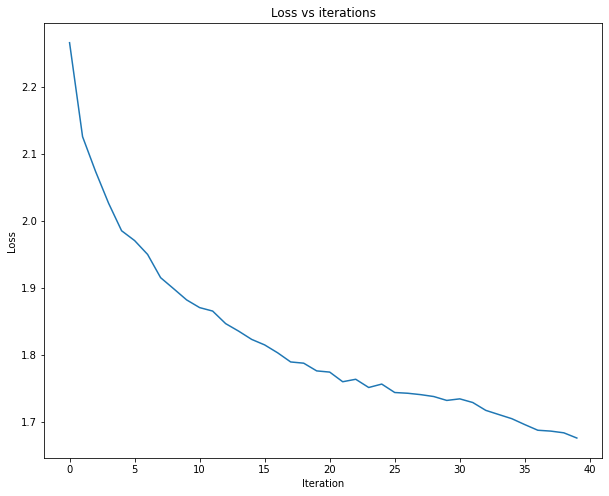

In [20]:
plt.figure(figsize=(10, 8))
plt.plot(loss_list)
plt.title("Loss vs iterations")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.show() 

# 6. Analysing the output incluiding testing

Test the model with the test data and compute accuracy.

In [21]:
#Load the model
vgg.load_state_dict(torch.load(results_path+'/vgg_model_11.ckpt'))

# Test the model
if True : 
    # Load test dataset
    IRMASTest = IRMAS(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(dataset=IRMASTest,
                                               batch_size=16, 
                                               shuffle=True)
    vgg.eval() # Set the model in evaluation mode
    
    # Compute testing accuracy
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device).float()
            labels = labels.to(device).float()
            # get network predictions
            outputs = vgg(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
        print('Test Accuracy of the model on the' + str(len(X_test)) +  ' test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the1341 test images: 63.90753169276659 %
